## Prechecks

In [1]:
import torch
from helpers.ImageFolderPathsIndices import get_dataloader, get_mean_std

### Get the mean and std of training data

Credit: [How to Normalize Image Dataset Using Pytorch](https://saturncloud.io/blog/how-to-normalize-image-dataset-using-pytorch/#:~:text=This%20is%20done%20by%20scaling,train%20and%20improve%20its%20accuracy.)

In [4]:
train_loader = get_dataloader('SC-2000v2', 32, 'train', train_aug=False, normalize='none')
mean, std = get_mean_std(train_loader)
print(mean)
print(std)

tensor([0.5744, 0.4826, 0.4668])
tensor([0.1406, 0.1537, 0.1575])


### Test if using MPS backend

In [22]:
if __name__ == '__main__':
  # Check if MPS backend is available in PyTorch
  if torch.backends.mps.is_available():
      # Create a vector on the MPS device
      x = torch.ones(1, device='mps')
      print(x)
  else:
      print('MPS device not found.')

tensor([1.], device='mps:0')


# Model Pipeline

**Sources:**
- [Training loop](https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/)
- [Image transforms](https://pytorch.org/vision/stable/transforms.html)
- [MPS backend](https://stackoverflow.com/questions/77226100/snn-that-works-on-cpu-throws-mismatched-tensor-types-in-nnpack-convolutionoutpu)
- [W&B Tutorial](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb#scrollTo=rmPkh7VRXdrr)

### Import libraries

In [1]:
import torch
import random
import wandb
import os.path
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import helpers.fc_models as fc_models
import helpers.conv_models as conv_models
from helpers.ImageFolderPathsIndices import get_dataloader
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm

# Fix seed for reproducible results
np.random.seed(2)
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(2)
random.seed(2)

### Define the model pipeline with WandB

In [2]:
def model_pipeline(project, hyperparameters):
    with wandb.init(project=project, config=hyperparameters):
        config = wandb.config

        model, train_loader, valid_loader, test_loader, criterion, optimizer = make(config)
        print(config.fc_model, config.conv_model)
        print(model)
        
        # and use them to train the model
        train(model, train_loader, valid_loader, criterion, optimizer, config)

        # and test its final performance
        return test(model, test_loader, config)

### Handles initializing model for experiment

In [3]:
def make(config):
    # Create dataset loaders
    # NOTE: returns a tuple with form (index, image, label, file_path)
    train_loader = get_dataloader(config.dataset, config.batch_size, 'train', config.train_aug, config.normalize)
    valid_loader = get_dataloader(config.dataset, config.batch_size, 'valid', config.train_aug, config.normalize)
    test_loader = get_dataloader(config.dataset, config.batch_size, 'test', config.train_aug, config.normalize)

    if config.conv_model == 'conv3':
        conv_model = conv_models.Conv3(config.c1_out, config.c2_out, config.c3_out)
        conv_out = config.c3_out
    elif config.conv_model == 'conv4':
        conv_model = conv_models.Conv4(config.c1_out, config.c2_out, config.c3_out, config.c4_out)
        conv_out = config.c4_out
    else:
    # Otherwise, skip
        raise ValueError(f'`conv_model` field of config should be one of {conv_models.CONV_NAMES}')

    
    # Set fc model
    if config.fc_model == 'lin1':
        fc_model = fc_models.Lin1(conv_out, config.output)
    elif config.fc_model == 'lin2':
        fc_model = fc_models.Lin2(conv_out, config.fc2_in, config.output, config.dropout_rate)
    elif config.fc_model == 'lin3':
        fc_model = fc_models.Lin3(conv_out, config.fc2_in, config.fc3_in, config.output, config.dropout_rate)
    else:
        raise ValueError(f'`fc_model` field of config should be one of {fc_models.FC_NAMES}')
    
    # Chain conv model and fc model
    model = nn.Sequential(conv_model, fc_model)
    # Send model to device
    model.to(config.device)

    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, valid_loader, test_loader, criterion, optimizer

## Training loop

In [4]:
def train(model, train_loader, valid_loader, criterion, optimizer, config):
    # Tell wandb to watch the model gradients and weights
    wandb.watch(model, criterion, log="all", log_freq=10)

    for epoch in tqdm(range(config.epochs)):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for _, images, labels, _ in train_loader:
            # Send data to the same device as the model
            images, labels = images.to(config.device), labels.to(config.device)
            # Calculate loss and number of correct predictions
            loss, correct = train_batch(images, labels, model, optimizer, criterion)
            # Update counts
            train_loss += loss
            train_correct += correct
        # Log training loss and accuracy
        train_log(train_loss, train_correct / len(train_loader.dataset), epoch)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        for _, images, labels, _ in valid_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            loss, correct = val_batch(images, labels, model, criterion)
            val_loss += loss
            val_correct += correct
        val_log(val_loss, val_correct / len(valid_loader.dataset), epoch)
    
    if config.save_as == 'pth':
        torch.save(model.state_dict(), os.path.join('weights', f"{config.conv_model}_{config.fc_model}.pth"))


In [5]:
def train_batch(images, labels, model, optimizer, criterion):
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate number of correct predictions for batch
    _,predicted = torch.max(outputs.data, 1)

    correct_train = (predicted == labels).sum().item()
    # Return loss and number of correct predictions
    return loss.item(), correct_train

def val_batch(images, labels, model, criterion):
    outputs = model(images)
    # Calculate number of correct predictions for batch
    _,predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)
    correct_val = (predicted == labels).sum().item()
    return loss, correct_val

def train_log(loss, acc, epoch):
    # Log loss and accuracy to wandb
    wandb.log({"train/loss": loss, "train/accuracy": acc}, step=epoch)
    print(f"Training Epoch {epoch}: Loss = {loss}, Accuracy = {acc:%}")

def val_log(loss, acc, epoch):
    # Log loss and accuracy to wandb
    wandb.log({"validation/loss": loss, "validation/accuracy": acc}, step=epoch)
    print(f"Validation Epoch {epoch}: Loss = {loss}, Accuracy = {acc:%}")

## Testing

In [6]:
def test(model, test_loader, config):
    if config.save_as == 'pth':
        model.load_state_dict(torch.load(os.path.join('weights', f"{config.conv_model}_{config.fc_model}.pth")))
    model.to("cpu")
    model.eval()
    
    true_labels = torch.zeros(len(test_loader.dataset)).long()
    pred_labels = torch.zeros(len(test_loader.dataset)).long()
    ptr = 0
    
    with torch.no_grad():
        for batch, (indices, images, labels, paths) in enumerate(test_loader):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            print(f"Batch {batch}: Accuracy = {accuracy_score(labels, predicted):%}, " +
                  f"Recall = {recall_score(labels, predicted, zero_division=0):%}, Precision = {precision_score(labels, predicted):%}")
            
            # Record labels and predictions
            inds = ptr + torch.arange(labels.shape[0])
            true_labels.index_copy_(0, inds, labels)
            pred_labels.index_copy_(0, inds, predicted)
            ptr += labels.shape[0]

        # Log avg test accuracy
        wandb.log({"test/accuracy": accuracy_score(true_labels, pred_labels)})
        # return confusion matrix for run
        cm = confusion_matrix(true_labels, pred_labels)
        return cm

## Average Metrics from Multiple Trainings

In [7]:
def ensemble(project, config_dict, itr):
    cm = np.zeros((2,2))
    for i in range(itr):
        cm += model_pipeline(project, config_dict)
    cm /= itr
    return cm

# 4 Convolution + 2 Fully Connected Layers

### Hyperparameter configuration

In [8]:
config_dict = dict(
    learning_rate = 0.001,
    epochs = 20,
    batch_size = 32,
    conv_model = "conv4",
    fc_model = "lin2",
    normalize = "SC-2000v2",
    c1_out = 64,
    c2_out = 128,
    c3_out = 256,
    c4_out = 512,
    fc2_in = 100,
    output = 2,
    dropout_rate = 0.5,
    dataset = "SC-2000v2",
    train_aug = True,
    device = "mps",
    save_as = 'pth'
)

### Average Confusion Matrix Stats from 5 Trainings

In [9]:
cm = ensemble('conv4-sc2000', config_dict, 5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: livsworld (shenderm). Use `wandb login --relogin` to force relogin


lin2 conv4
Sequential(
  (0): Conv4(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, e

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 35.9472222328186, Accuracy = 56.964520%
Validation Epoch 0: Loss = 8.330469131469727, Accuracy = 65.977011%
Training Epoch 1: Loss = 30.434276312589645, Accuracy = 64.454665%
Validation Epoch 1: Loss = 8.4525146484375, Accuracy = 65.977011%
Training Epoch 2: Loss = 30.09969973564148, Accuracy = 67.017083%
Validation Epoch 2: Loss = 8.816344261169434, Accuracy = 59.770115%
Training Epoch 3: Loss = 30.2788143157959, Accuracy = 65.374507%
Validation Epoch 3: Loss = 8.519530296325684, Accuracy = 65.747126%
Training Epoch 4: Loss = 30.15706992149353, Accuracy = 65.571616%
Validation Epoch 4: Loss = 8.385772705078125, Accuracy = 71.264368%
Training Epoch 5: Loss = 30.04674905538559, Accuracy = 66.754271%
Validation Epoch 5: Loss = 7.885969161987305, Accuracy = 71.954023%
Training Epoch 6: Loss = 29.627570033073425, Accuracy = 67.017083%
Validation Epoch 6: Loss = 7.222415924072266, Accuracy = 78.850575%
Training Epoch 7: Loss = 28.732837170362473, Accuracy = 70.03942

/opt/anaconda3/envs/dermlens/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 0: Accuracy = 100.000000%, Recall = 0.000000%, Precision = 0.000000%
Batch 1: Accuracy = 90.625000%, Recall = 0.000000%, Precision = 0.000000%
Batch 2: Accuracy = 90.625000%, Recall = 0.000000%, Precision = 0.000000%
Batch 3: Accuracy = 71.875000%, Recall = 60.000000%, Precision = 92.307692%
Batch 4: Accuracy = 65.625000%, Recall = 65.625000%, Precision = 100.000000%
Batch 5: Accuracy = 87.500000%, Recall = 87.500000%, Precision = 100.000000%
Batch 6: Accuracy = 61.904762%, Recall = 61.904762%, Precision = 100.000000%


test/accuracy,▁
train/accuracy,▁▄▅▄▄▅▅▆▇▇▇▆▇▇▇▇▇▇██
train/loss,█▅▄▄▄▄▄▃▃▂▂▃▂▂▂▁▁▂▁▁
validation/accuracy,▃▃▁▃▄▅▇▇▇▇▇▇▆▅█▆▆█▇▇
validation/loss,▇▇█▇▇▆▅▄▃▄▂▃▃▄▂▃▄▁▂▁
test/accuracy,0.8216
train/accuracy,0.74376
train/loss,24.78969
validation/accuracy,0.8023
validation/loss,5.5334


lin2 conv4
Sequential(
  (0): Conv4(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, e

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 36.54399996995926, Accuracy = 52.628121%
Validation Epoch 0: Loss = 9.275635719299316, Accuracy = 57.011494%
Training Epoch 1: Loss = 31.72592854499817, Accuracy = 60.840999%
Validation Epoch 1: Loss = 9.108899116516113, Accuracy = 58.390805%
Training Epoch 2: Loss = 29.937693744897842, Accuracy = 67.608410%
Validation Epoch 2: Loss = 8.219414710998535, Accuracy = 68.275862%
Training Epoch 3: Loss = 30.285003781318665, Accuracy = 64.651774%
Validation Epoch 3: Loss = 7.56389856338501, Accuracy = 75.862069%
Training Epoch 4: Loss = 29.31871348619461, Accuracy = 67.674113%
Validation Epoch 4: Loss = 7.566342353820801, Accuracy = 71.494253%
Training Epoch 5: Loss = 27.94417616724968, Accuracy = 69.776610%
Validation Epoch 5: Loss = 7.128634929656982, Accuracy = 76.321839%
Training Epoch 6: Loss = 29.128047585487366, Accuracy = 66.688568%
Validation Epoch 6: Loss = 8.02140998840332, Accuracy = 65.517241%
Training Epoch 7: Loss = 27.119438469409943, Accuracy = 71.35

/opt/anaconda3/envs/dermlens/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 0: Accuracy = 100.000000%, Recall = 0.000000%, Precision = 0.000000%
Batch 1: Accuracy = 93.750000%, Recall = 0.000000%, Precision = 0.000000%
Batch 2: Accuracy = 87.500000%, Recall = 0.000000%, Precision = 0.000000%
Batch 3: Accuracy = 75.000000%, Recall = 65.000000%, Precision = 92.857143%
Batch 4: Accuracy = 65.625000%, Recall = 65.625000%, Precision = 100.000000%
Batch 5: Accuracy = 81.250000%, Recall = 81.250000%, Precision = 100.000000%
Batch 6: Accuracy = 57.142857%, Recall = 57.142857%, Precision = 100.000000%


test/accuracy,▁
train/accuracy,▁▄▆▅▆▆▅▇▆▇▇▇█▇▇█████
train/loss,█▅▄▄▄▃▄▂▄▂▂▂▂▂▂▁▂▁▁▁
validation/accuracy,▁▁▄▆▅▆▃▆▅▅▆▇▆▆▆▆█▅▆▆
validation/loss,██▆▅▅▄▅▂▅▃▂▂▂▃▃▃▁▄▂▂
test/accuracy,0.81221
train/accuracy,0.74507
train/loss,24.77696
validation/accuracy,0.77011
validation/loss,6.17354


lin2 conv4
Sequential(
  (0): Conv4(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, e

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 35.64788430929184, Accuracy = 50.854139%
Validation Epoch 0: Loss = 9.652990341186523, Accuracy = 54.712644%
Training Epoch 1: Loss = 32.9249906539917, Accuracy = 52.956636%
Validation Epoch 1: Loss = 9.060675621032715, Accuracy = 64.597701%
Training Epoch 2: Loss = 31.85523223876953, Accuracy = 57.884363%
Validation Epoch 2: Loss = 8.713546752929688, Accuracy = 66.206897%
Training Epoch 3: Loss = 30.586967527866364, Accuracy = 63.534823%
Validation Epoch 3: Loss = 8.02983283996582, Accuracy = 73.333333%
Training Epoch 4: Loss = 29.751200050115585, Accuracy = 64.191853%
Validation Epoch 4: Loss = 7.244480133056641, Accuracy = 76.551724%
Training Epoch 5: Loss = 29.169901311397552, Accuracy = 67.477004%
Validation Epoch 5: Loss = 7.197332382202148, Accuracy = 79.540230%
Training Epoch 6: Loss = 29.053949803113937, Accuracy = 67.017083%
Validation Epoch 6: Loss = 7.179614543914795, Accuracy = 74.712644%
Training Epoch 7: Loss = 28.788114458322525, Accuracy = 67.9

test/accuracy,▁
train/accuracy,▁▂▃▅▅▆▆▆▆▆▇▇▇▇▇█████
train/loss,█▆▅▄▄▃▃▃▃▃▂▂▁▂▁▁▁▁▁▁
validation/accuracy,▁▄▄▆▇▇▆▆▇▇█▇▇██▇▇▇▇█
validation/loss,█▇▆▅▄▄▄▅▃▃▃▂▂▂▂▃▂▂▂▁
test/accuracy,0.79343
train/accuracy,0.72799
train/loss,26.18273
validation/accuracy,0.81609
validation/loss,5.53062


lin2 conv4
Sequential(
  (0): Conv4(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, e

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 35.07924395799637, Accuracy = 51.971091%
Validation Epoch 0: Loss = 9.037671089172363, Accuracy = 68.045977%
Training Epoch 1: Loss = 30.711496889591217, Accuracy = 63.534823%
Validation Epoch 1: Loss = 8.062993049621582, Accuracy = 71.034483%
Training Epoch 2: Loss = 30.83554995059967, Accuracy = 62.943495%
Validation Epoch 2: Loss = 9.530536651611328, Accuracy = 59.540230%
Training Epoch 3: Loss = 30.582126677036285, Accuracy = 65.571616%
Validation Epoch 3: Loss = 8.257742881774902, Accuracy = 73.563218%
Training Epoch 4: Loss = 29.916546761989594, Accuracy = 66.754271%
Validation Epoch 4: Loss = 8.12732982635498, Accuracy = 70.344828%
Training Epoch 5: Loss = 29.922754228115082, Accuracy = 65.768725%
Validation Epoch 5: Loss = 7.972021102905273, Accuracy = 71.264368%
Training Epoch 6: Loss = 28.914004653692245, Accuracy = 69.119580%
Validation Epoch 6: Loss = 6.943778038024902, Accuracy = 76.781609%
Training Epoch 7: Loss = 28.26846820116043, Accuracy = 70.

/opt/anaconda3/envs/dermlens/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 0: Accuracy = 100.000000%, Recall = 0.000000%, Precision = 0.000000%
Batch 1: Accuracy = 93.750000%, Recall = 0.000000%, Precision = 0.000000%
Batch 2: Accuracy = 90.625000%, Recall = 0.000000%, Precision = 0.000000%
Batch 3: Accuracy = 71.875000%, Recall = 60.000000%, Precision = 92.307692%
Batch 4: Accuracy = 59.375000%, Recall = 59.375000%, Precision = 100.000000%
Batch 5: Accuracy = 90.625000%, Recall = 90.625000%, Precision = 100.000000%
Batch 6: Accuracy = 61.904762%, Recall = 61.904762%, Precision = 100.000000%


test/accuracy,▁
train/accuracy,▁▄▄▅▅▅▆▆▆▆▇▇▆▇▇▇█▇██
train/loss,█▅▅▅▅▅▄▃▄▃▂▃▂▂▂▂▂▁▁▁
validation/accuracy,▄▄▁▅▄▅▆▃▆▇▇▆██▇▆▅██▇
validation/loss,▇▅█▆▆▅▃▅▄▃▃▃▁▂▁▃▃▁▁▁
test/accuracy,0.8216
train/accuracy,0.76281
train/loss,24.74948
validation/accuracy,0.8023
validation/loss,5.69098


lin2 conv4
Sequential(
  (0): Conv4(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, e

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 34.490274131298065, Accuracy = 58.607096%
Validation Epoch 0: Loss = 9.165016174316406, Accuracy = 57.701149%
Training Epoch 1: Loss = 31.38177525997162, Accuracy = 62.483574%
Validation Epoch 1: Loss = 8.532574653625488, Accuracy = 66.206897%
Training Epoch 2: Loss = 30.39893788099289, Accuracy = 65.505913%
Validation Epoch 2: Loss = 8.13010025024414, Accuracy = 71.034483%
Training Epoch 3: Loss = 29.81227472424507, Accuracy = 66.819974%
Validation Epoch 3: Loss = 7.482412815093994, Accuracy = 75.172414%
Training Epoch 4: Loss = 28.985639363527298, Accuracy = 68.659658%
Validation Epoch 4: Loss = 6.846088886260986, Accuracy = 78.850575%
Training Epoch 5: Loss = 28.804597705602646, Accuracy = 68.659658%
Validation Epoch 5: Loss = 7.560451507568359, Accuracy = 71.954023%
Training Epoch 6: Loss = 28.09718006849289, Accuracy = 69.645204%
Validation Epoch 6: Loss = 6.630341529846191, Accuracy = 76.321839%
Training Epoch 7: Loss = 27.78751254081726, Accuracy = 69.11

/opt/anaconda3/envs/dermlens/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 0: Accuracy = 100.000000%, Recall = 0.000000%, Precision = 0.000000%
Batch 1: Accuracy = 84.375000%, Recall = 0.000000%, Precision = 0.000000%
Batch 2: Accuracy = 84.375000%, Recall = 0.000000%, Precision = 0.000000%
Batch 3: Accuracy = 75.000000%, Recall = 65.000000%, Precision = 92.857143%
Batch 4: Accuracy = 65.625000%, Recall = 65.625000%, Precision = 100.000000%
Batch 5: Accuracy = 84.375000%, Recall = 84.375000%, Precision = 100.000000%
Batch 6: Accuracy = 61.904762%, Recall = 61.904762%, Precision = 100.000000%


test/accuracy,▁
train/accuracy,▁▃▄▅▅▅▆▆▆▆▆▅▆█▇█▇███
train/loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
validation/accuracy,▁▄▅▆▇▅▇█▇█▄▇█▇█▇█▆██
validation/loss,█▇▆▅▄▅▃▃▃▃▅▂▃▂▂▂▂▄▁▂
test/accuracy,0.80282
train/accuracy,0.7477
train/loss,24.53711
validation/accuracy,0.8
validation/loss,5.83403


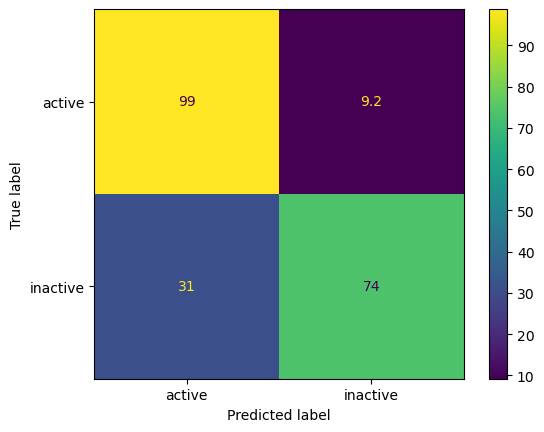

In [10]:
display = ConfusionMatrixDisplay(cm, display_labels=["active", "inactive"])
display.plot()

### Run pipeline once

lin2 conv4
Sequential(
  (0): Conv4(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, e

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 35.64788430929184, Accuracy = 50.854139%
Validation Epoch 0: Loss = 9.652990341186523, Accuracy = 54.712644%
Training Epoch 1: Loss = 32.9249906539917, Accuracy = 52.956636%
Validation Epoch 1: Loss = 9.060675621032715, Accuracy = 64.597701%
Training Epoch 2: Loss = 31.85523223876953, Accuracy = 57.884363%
Validation Epoch 2: Loss = 8.713546752929688, Accuracy = 66.206897%
Training Epoch 3: Loss = 30.586967527866364, Accuracy = 63.534823%
Validation Epoch 3: Loss = 8.02983283996582, Accuracy = 73.333333%
Training Epoch 4: Loss = 29.751200050115585, Accuracy = 64.191853%
Validation Epoch 4: Loss = 7.244480133056641, Accuracy = 76.551724%
Training Epoch 5: Loss = 29.169901311397552, Accuracy = 67.477004%
Validation Epoch 5: Loss = 7.197332382202148, Accuracy = 79.540230%
Training Epoch 6: Loss = 29.053949803113937, Accuracy = 67.017083%
Validation Epoch 6: Loss = 7.179614543914795, Accuracy = 74.712644%
Training Epoch 7: Loss = 28.788114458322525, Accuracy = 67.9

test/accuracy,▁
train/accuracy,▁▂▃▅▅▆▆▆▆▆▇▇▇▇▇█████
train/loss,█▆▅▄▄▃▃▃▃▃▂▂▁▂▁▁▁▁▁▁
validation/accuracy,▁▄▄▆▇▇▆▆▇▇█▇▇██▇▇▇▇█
validation/loss,█▇▆▅▄▄▄▅▃▃▃▂▂▂▂▃▂▂▂▁
test/accuracy,0.79343
train/accuracy,0.72799
train/loss,26.18273
validation/accuracy,0.81609
validation/loss,5.53062


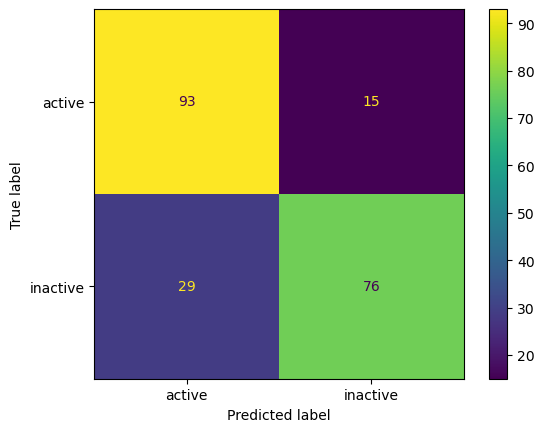

In [12]:
model_pipeline('conv4-sc2000', config_dict)

# 3 Convolution + 2 Fully Connected Layers

### Hyperparameter configuration

In [50]:
config_dict = dict(
    learning_rate = 0.001,
    epochs = 20,
    batch_size = 32,
    conv_model = "conv3",
    fc_model = "lin2",
    normalize = "SC-2000",
    c1_out = 64,
    c2_out = 128,
    c3_out = 256,
    fc1_in = 256,
    fc2_in = 100,
    fc3_in = 50,
    output = 2,
    dropout_rate = 0.5,
    dataset = "SC-2000",
    train_aug = True,
    device = "mps",
    save_as = 'pth'
)

### Run pipeline

lin2 conv3
Sequential(
  (0): Conv3(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (1): Lin2(
    (fc1): Linear(in_features=256, out_features=100, bias=True)
    (act1): ReLU()
    (dropout1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=100, out_featur

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 33.8948677778244, Accuracy = 50.358306%
Validation Epoch 0: Loss = 9.53052806854248, Accuracy = 61.149425%
Training Epoch 1: Loss = 33.24182951450348, Accuracy = 52.573290%
Validation Epoch 1: Loss = 9.272360801696777, Accuracy = 61.839080%
Training Epoch 2: Loss = 33.094289898872375, Accuracy = 55.048860%
Validation Epoch 2: Loss = 9.576562881469727, Accuracy = 56.781609%
Training Epoch 3: Loss = 33.13936221599579, Accuracy = 55.765472%
Validation Epoch 3: Loss = 9.515780448913574, Accuracy = 56.551724%
Training Epoch 4: Loss = 32.80048751831055, Accuracy = 56.026059%
Validation Epoch 4: Loss = 9.407020568847656, Accuracy = 59.310345%
Training Epoch 5: Loss = 32.63172489404678, Accuracy = 57.719870%
Validation Epoch 5: Loss = 9.204687118530273, Accuracy = 61.609195%
Training Epoch 6: Loss = 32.9735044836998, Accuracy = 55.114007%
Validation Epoch 6: Loss = 9.092361450195312, Accuracy = 66.896552%
Training Epoch 7: Loss = 32.53997951745987, Accuracy = 58.110749

test/accuracy,▁
train/accuracy,▁▂▃▄▄▅▃▅▄▅▆▅▆▇▇▆█▇▇█
train/loss,█▆▆▆▅▅▆▅▄▄▃▄▄▃▃▃▁▂▁▁
validation/accuracy,▃▃▁▁▂▃▅▂▃▄▅▄▃▅▅▅█▆▆█
validation/loss,█▆██▇▆▆▆▆▅▄▄▅▄▃▅▁▂▂▁
test/accuracy,0.75
train/accuracy,0.63648
train/loss,31.07297
validation/accuracy,0.74253
validation/loss,8.23367


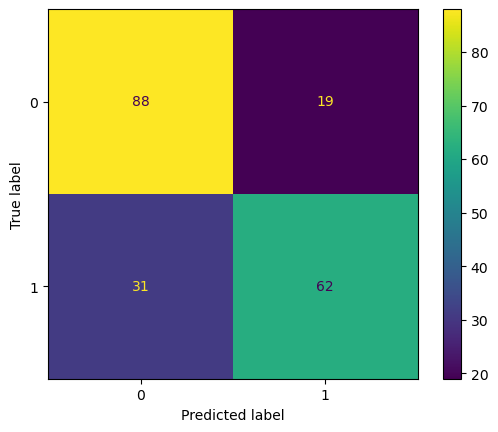

In [51]:
model_pipeline('conv3-sc2000', config_dict)

# Sweep

**[To Create a New Sweep](https://docs.wandb.ai/ref/cli/wandb-sweep)**

``wandb sweep -p projectname sweep_configs/config.yaml``

In [ ]:
def sweep_pipeline(config=None):
    with wandb.init(config=config):
        config = wandb.config

        model, train_loader, valid_loader, test_loader, criterion, optimizer = make(config)

        # and use them to train the model
        train(model, train_loader, valid_loader, criterion, optimizer, config)

        # and test its final performance
        test(model, test_loader, config)

    return model

Replace with the desired sweep and project

In [ ]:
sweep_id = 'your-id-here'
project = 'conv4-sc2000'

In [ ]:
wandb.agent(sweep_id, sweep_pipeline, count=12, project=project)
wandb.teardown()